# Multiclass Classification with TensorFlow

#### The Dataset used for the task: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

#### Importing libs

In [56]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import pathlib

#### Preparing data storage

In [59]:
# Set base root dir path to images data
root_path = "/work/Personal_CG_Learning/REBELWAY/Intro_to_Machine_Learning/Source/Datasets/Vegetable_Images"

In [60]:
os.listdir(root_path)

['train', 'test', 'validation']

In [61]:
# Path for specific data
train_dir = root_path + "/train"
test_dir = root_path + "/test"
val_dir = root_path + "/validation"

In [62]:
# Get types names
data_dir = pathlib.Path(root_path + "/train")
types_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

print(types_names)

['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


In [63]:
# Function for showing randomly selected image from the dataset
def random_img(dirpath, target_class):
    directory = dirpath + "/" + target_class
    random_img = random.sample(os.listdir(directory), 1)

    img = mpimg.imread(directory + "/" + random_img[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")

    return img

Image shape: (224, 224, 3)


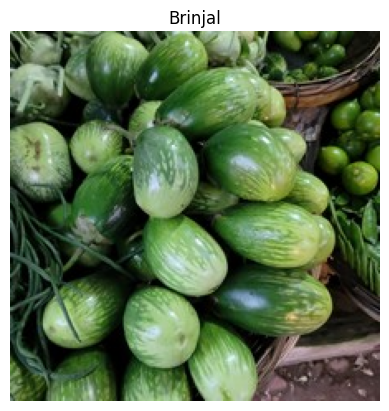

In [65]:
img = random_img(train_dir, random.choice(os.listdir(train_dir)))

#### Preparing Train, Test and Validation dataset

In [66]:
# Data creation for train, test and val
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 shuffle=False)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 shuffle=False)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


#### Additional functions

In [67]:
# Data Augmentation function
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.02),
    tf.keras.layers.RandomZoom(0.02),
])

In [68]:
# Checkpoin saving function
checkpoint_path = "checkpoints/checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_accuracy",
    save_freq="epoch",
    verbose=1
)

#### Basemode creation with ConvNeXtSmall architecture

In [69]:
# Base model creation using Tensorflow pretrained model
base_model = tf.keras.applications.ConvNeXtSmall(include_top=False)
base_model.trainable=False
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
x = tf.keras.layers.Dense(len(types_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
)

In [70]:
# Checking model summary
model_0.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 7, 7, 768)      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │        11,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 15)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,466,223 (188.70 MB)

 Trainable params: 11,535 (45.06 KB)

 Non-trainable params: 49,454,688 (188.65 MB)

In [71]:
# Fitting the model
model_0_loss = model_0.fit(train_data,
                           epochs=5,
                           validation_data=val_data,
                           validation_steps=len(val_data),
                           callbacks=[checkpoint_callback])

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8141 - loss: 0.7675
Epoch 1: val_accuracy improved from -inf to 0.98667, saving model to checkpoints/checkpoint.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 192ms/step - accuracy: 0.8144 - loss: 0.7666 - val_accuracy: 0.9867 - val_loss: 0.0816
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9890 - loss: 0.0725
Epoch 2: val_accuracy improved from 0.98667 to 0.99100, saving model to checkpoints/checkpoint.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.9890 - loss: 0.0725 - val_accuracy: 0.9910 - val_loss: 0.0429
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9954 - loss: 0.0379
Epoch 3: val_accuracy improved from 0.99100 to 0.99533, saving model to checkpoints/checkpoint.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 172ms/step - accuracy: 0.9954 - loss: 0.0379 - val_accuracy: 0.9953 - val_loss: 0.0271
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy

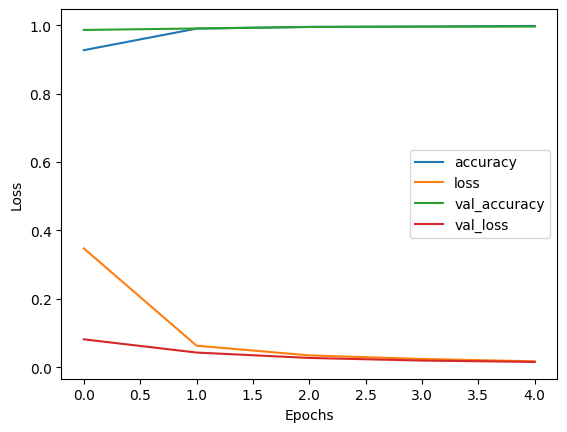

In [72]:
# Checking model's training history
pd.DataFrame(model_0_loss.history).plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [73]:
model_0.evaluate(test_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9974 - loss: 0.0151


[0.014974008314311504, 0.9973333477973938]

#### Improving the model by re-training

In [74]:
# Making the model trainable and unlock last 10 layers
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable=False

In [75]:
# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["accuracy"])

In [76]:
# Re-traine it
model_0_new_loss = model_0.fit(train_data,
                               epochs=8,
                               initial_epoch=model_0_loss.epoch[-1],
                               validation_data=val_data,
                               validation_steps=len(val_data))

Epoch 5/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 211ms/step - accuracy: 0.9926 - loss: 0.0321 - val_accuracy: 0.9943 - val_loss: 0.0150
Epoch 6/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 89s 191ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 0.9990 - val_loss: 0.0031
Epoch 7/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 89s 190ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9993 - val_loss: 0.0013
Epoch 8/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 89s 190ms/step - accuracy: 1.0000 - loss: 2.4533e-04 - val_accuracy: 0.9997 - val_loss: 0.0013


In [77]:
# Checking model evaluation on Test data
model_0.evaluate(test_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.9984 - loss: 0.0037


[0.002735197078436613, 0.9986666440963745]

#### Saving and loading model

In [78]:
# Saving the model
model_0.save("saved_model/model_0.keras")

In [79]:
# Loading model from the path
model = tf.keras.models.load_model("saved_model/model_0.keras")

In [80]:
# Checking model after the loading
results = model.evaluate(test_data)
pred_probs = model.predict(test_data, verbose=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - accuracy: 0.9984 - loss: 0.0037
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 187ms/step


#### Checking model prediction output on Test data

In [81]:
# Function for preparing images for display
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


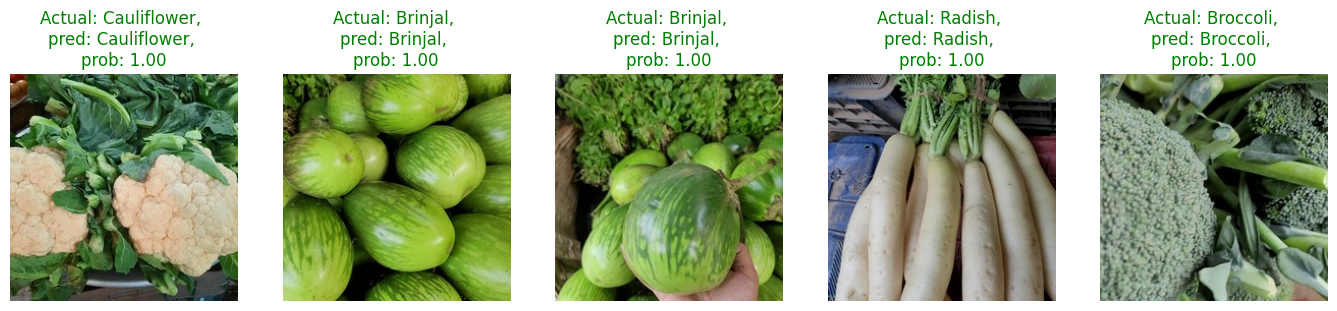

In [82]:
# Displaying testing data prediction

count = 5

plt.figure(figsize=(17,10))
for i in range(count):
  class_name = random.choice(types_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded)
  pred_class = types_names[pred_prob.argmax()]

  plt.subplot(1,count,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"Actual: {class_name}, \npred: {pred_class}, \nprob: {pred_prob.max():.2f}", c=title_color)
  plt.axis("off");

#### Checking the prediction result on our own data

In [83]:
cust_test_dir = "/work/Personal_CG_Learning/REBELWAY/Intro_to_Machine_Learning/Source/Datasets/Vegetable_Custom_Test"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


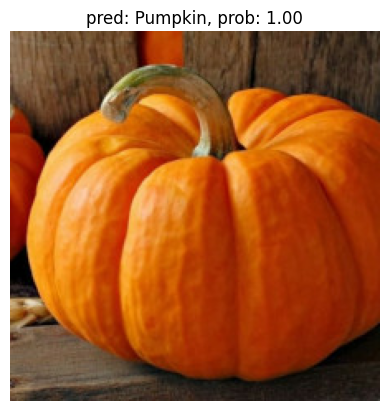

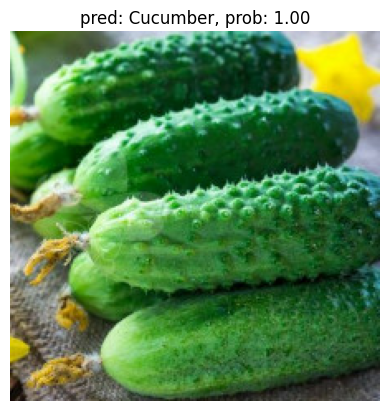

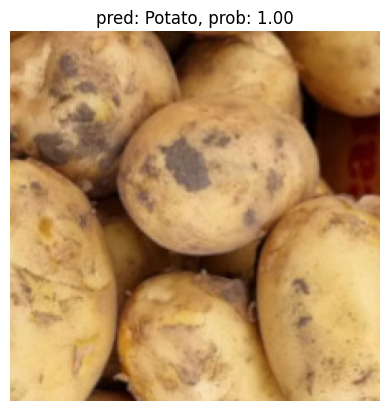

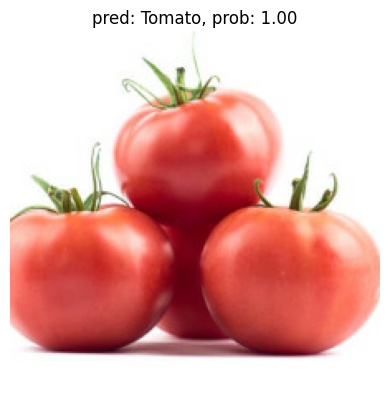

In [84]:
for image in os.listdir(cust_test_dir):
    img = load_and_prep_image(os.path.join(cust_test_dir,image), scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = types_names[pred_prob.argmax()]

    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis('off');